In [1]:
import os, sys

sys.path.insert(0, os.path.abspath('..'))
os.environ['USE_PYGEOS'] = '0'

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

True

True

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from google.cloud import storage
from google.oauth2 import service_account
import json

import gc
gc.enable()

import glob

from rasterio.plot import show
import rasterio
from rasterio.merge import merge
from rasterio.transform import from_origin
from rasterio.enums import Resampling

In [3]:
from google.cloud import storage
from project_config import GCP_PROJECT_NAME, DATASET_JSON_PATH
import json
import matplotlib.pyplot as plt

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

2023-12-19 18:27:07:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpn3j57vq9
2023-12-19 18:27:07:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpn3j57vq9


In [4]:
# from utils.data_management import all_observations_for_location
from utils.data_management import observation_factory

In [5]:
#### Configuration

from experiment_configs.configs import unet_config, satmae_large_config, satmae_large_inf_config
# config = satmae_large_config
config = satmae_large_inf_config



In [ ]:
def map_fishnet_to_chunk(fishnet, chunk):
    """
    Function to take an optimal chunk and get the list of fishnet grids in it. 
    """
    fcols = fishnet.columns
    ccols = chunk.columns
    
    dropcols = []
    
    for c in ['index_left', 'index_right']:
        if (c in fcols):
            fishnet = fishnet.drop(columns = [c])
        if (c in ccols):
            chunk = chunk.drop(columns = [c])
            
    df_tiles = gpd.sjoin(fishnet, chunk)
    
    unique_chunks = df_tiles['id_right'].unique()
    
    tile_dict = {}
    
    for idval in unique_chunks:
        fishnets = df_tiles[df_tiles['id_right'] == idval ]['id_left'].values
        tile_dict[idval] = fishnets
    return tile_dict

#This will run inference on every image in the validation set
filter_oos = lambda x: oos_json.id == x 

from enum import Enum
from dataclasses import dataclass
from typing import Optional

@dataclass
class OosPointer:
    uris_to_s1: list
    uris_to_s2: list
    uris_to_s2_l1c: list
#     uris_to_rgb: Optional[list]
#     uri_to_rivers: Optional[str]
#     name: Optional[str]
    f_id: [int] # 
        
def oos_factory(chunk_json, chunk_id):
    #iterate over json file and create ObservationPointer
    s1_uris = []
    s2_uris = []
    s2_l1c_uris = []
    
    for chunk in chunk_json:
        s1_uris.append(chunk['uri_to_s1'])
        s2_uris.append(chunk['uri_to_s2'])
        s2_l1c_uris.append(chunk['uri_to_s2_l1c'])
        
    oos = OosPointer(
                uris_to_s1 = s1_uris,
                uris_to_s2 = s2_uris,
                uris_to_s2_l1c = s2_l1c_uris,
                f_id=  chunk_id
        )
    return oos

#### Read Fishnet and Optimal Chunks

In [6]:
sone_grids = gpd.read_file('/data/sand_mining/rivers/river_grids/sone.geojson') #Fishnet covering Sone
sone_optimal = gpd.read_file('/data/sand_mining/rivers/chunks/sone.geojson') #Optimal Chunks

In [7]:
# oos_json = json.load(open('/data/sand_mining/oos/oos_grids.json', 'r')) 

#Read master fishnet files (for all of india)
df_oos = pd.read_json('/data/sand_mining/oos/oos_grids.json')
df_oos = df_oos.rename(columns = {'id':'f_id'})

In [9]:
### Create a dictionary with grid ids associated with each chunk

sone_chunk_dict = map_fishnet_to_chunk(sone_grids, sone_optimal)

In [18]:
from utils.rastervision_pipeline import create_s2_image_source, create_scene_s2, scene_to_inference_ds

In [ ]:
#### NOTE: Rastervision can do the mosaicking on the fly (by building virtual rasters)
#### however this requires gdalvrt, which is currently not on Josh's servers
#### Follow up with Steve to figure this out. 

### Chunk-wise rasters  (OLD WORKFLOW)

In [52]:
for chunk_id, chunk in sone_chunk_dict.items():
    chunk_subset = df_oos[df_oos['f_id'].isin(chunk)]
    chunk_subset['river'] = "Sone"
    chunk_json = json.loads(chunk_subset.to_json(orient= 'records'))
#     chunk_json = eval(fr"{jchunk_subset.to_json(orient= 'records')}")
    
    oos_obj = oos_factory(chunk_json = chunk_json, 
                          chunk_id = chunk_id)
    
    print("***************")
    print(chunk_id, datetime.now())
    print(f"Merging {len(oos_obj.uris_to_s2)} images")
    with rasterio.Env():
        print("Reading Files", datetime.now())
        src_files_to_mosaic = [rasterio.open(gcs_file) for gcs_file in oos_obj.uris_to_s2]

        print("Making Mosaic", datetime.now())
        mosaic, out_trans = merge(src_files_to_mosaic)

        print("Writing", datetime.now())
        # Create a new raster file for the merged result
        with rasterio.open(f"/data/sand_mining/predictions/raw/sone/chunk_{chunk_id}.tif", 'w', 
                           driver='GTiff', 
                           height=mosaic.shape[1], 
                           width=mosaic.shape[2], 
                           count=12,
                           dtype=mosaic.dtype, 
                           crs=src_files_to_mosaic[0].crs, 
                           transform=out_trans) as dest:
            dest.write(mosaic)

***************
0 2023-12-19 21:28:49.908850
Merging 13 images
Reading Files 2023-12-19 21:28:49.910536
Making Mosaic 2023-12-19 21:29:00.379882
Writing 2023-12-19 21:29:09.681070
***************
1 2023-12-19 21:29:10.406958
Merging 13 images
Reading Files 2023-12-19 21:29:10.407652
Making Mosaic 2023-12-19 21:29:17.786613
Writing 2023-12-19 21:29:26.085350
***************
2 2023-12-19 21:29:26.810481
Merging 11 images
Reading Files 2023-12-19 21:29:26.811179
Making Mosaic 2023-12-19 21:29:32.447930
Writing 2023-12-19 21:29:39.225362
***************
3 2023-12-19 21:29:39.907789
Merging 13 images
Reading Files 2023-12-19 21:29:39.908504
Making Mosaic 2023-12-19 21:29:47.540175
Writing 2023-12-19 21:29:56.134454
***************
4 2023-12-19 21:29:57.245790
Merging 19 images
Reading Files 2023-12-19 21:29:57.247043
Making Mosaic 2023-12-19 21:30:09.164485
Writing 2023-12-19 21:30:21.851269
***************
5 2023-12-19 21:30:23.242101
Merging 15 images
Reading Files 2023-12-19 21:30:23.242

#### SINGLE RASTER  (LATEST WORKFLOW)

In [86]:
#### URIS for Single Merged Raster
all_uris = []
for chunk_id, chunk in sone_chunk_dict.items():
    chunk_subset = df_oos[df_oos['f_id'].isin(chunk)]
    chunk_subset['river'] = "Sone"
    chunk_json = json.loads(chunk_subset.to_json(orient= 'records'))
#     chunk_json = eval(fr"{jchunk_subset.to_json(orient= 'records')}")
    
    oos_obj = oos_factory(chunk_json = chunk_json, 
                          chunk_id = chunk_id)
    
    all_uris.extend(oos_obj.uris_to_s2)

In [87]:
print(len(all_uris))
all_uris = list(np.unique(all_uris))
print(len(all_uris))

150
115


In [94]:
### Create single merged raster

print(f"Merging {len(all_uris)} images")
with rasterio.Env():
    print("Reading Files", datetime.now())
    src_files_to_mosaic = [rasterio.open(gcs_file) for gcs_file in all_uris]

    print("Making Mosaic", datetime.now())
    mosaic, out_trans = merge(src_files_to_mosaic)

    print("Writing", datetime.now())
    # Create a new raster file for the merged result
    with rasterio.open(f"/data/sand_mining/predictions/raw/sone/sone_merged.tif", 'w', 
                       driver='GTiff', 
                       height=mosaic.shape[1], 
                       width=mosaic.shape[2], 
                       count=12,
                       dtype=mosaic.dtype, 
                       crs=src_files_to_mosaic[0].crs, 
                       transform=out_trans) as dest:
        dest.write(mosaic)

Merging 115 images
Reading Files 2023-12-21 08:24:42.241376
Making Mosaic 2023-12-21 08:25:12.084035
Writing 2023-12-21 08:26:30.008391


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


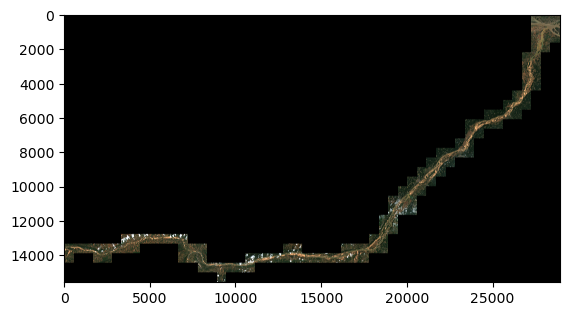

<Axes: >

In [96]:
src = "/data/sand_mining/predictions/raw/sone/sone_merged.tif"
src = rasterio.open(src)
data = src.read([4,3,2])/3500
show(data)

In [54]:
# filename = "/data/sand_mining/predictions/raw/sone/chunk_5.tif"
# src = rasterio.open(filename)
# data = src.read([4,3,2])/3500
# show(data)

# r_source = create_s2_image_source(config, "https://storage.googleapis.com/sand_mining_grids/test_chunk.tif")

#### Move chunks to cloud

In [55]:


import subprocess

gcp_move = """gsutil cp -r /data/sand_mining/predictions/raw/sone gs://sand_mining_grids/merged"""
try:
    # Run the gsutil command
    subprocess.run(gcp_move, shell=True, check=True)
    print(f"Files copied successfully to GCP Bucket")
except subprocess.CalledProcessError as e:
    print(f"Error copying files: {e}")

Copying file:///data/sand_mining/predictions/raw/sone/chunk_0.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file:///data/sand_mining/predictions/raw/sone/chunk_1.tif [Content-Type=image/tiff]...
Copying file:///data/sand_mining/predictions/raw/sone/chunk_2.tif [Content-Type=image/tiff]...
Copying file:///data/sand_min

Files copied successfully to GCP Bucket


/ [10 files][  9.5 GiB/  9.5 GiB]  118.0 MiB/s                                  
-
Operation completed over 10 objects/9.5 GiB.                                     


#### Move single raster to cloud

In [97]:


gcp_move = """gsutil cp /data/sand_mining/predictions/raw/sone/sone_merged.tif gs://sand_mining_grids/merged/sone_merged.tif"""
try:
    # Run the gsutil command
    subprocess.run(gcp_move, shell=True, check=True)
    print(f"Files copied successfully to GCP Bucket")
except subprocess.CalledProcessError as e:
    print(f"Error copying files: {e}")

Copying file:///data/sand_mining/predictions/raw/sone/sone_merged.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.



Files copied successfully to GCP Bucket


| [1 files][ 40.3 GiB/ 40.3 GiB]  148.4 MiB/s                                   
/
Operation completed over 1 objects/40.3 GiB.                                     


In [60]:
from ml.learner import BinarySegmentationPredictor
from models.model_factory import model_factory

#### Load Model

In [61]:

s2_uri = "https://storage.googleapis.com/sand_mining_grids/merged/sone/chunk_0.tif"
r_source_temp = create_scene_s2(config, s2_uri, label_uri = None, scene_id = 0, rivers_uri = None)

from ml.learner import BinarySegmentationPredictor
from models.model_factory import model_factory


_, _, n_channels = r_source_temp.raster_source.shape
model = model_factory(
    config,
    n_channels=n_channels,
)

predictor = BinarySegmentationPredictor(
    config, model, config.encoder_weights_path
)


2023-12-19 21:42:53:rastervision.pipeline.file_system.utils: INFO - Using cached file /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone/chunk_0.tif.


SatMae: Loading encoder weights from /data/sand_mining/checkpoints/finetuned/SatMAE-L_b128-BatchNormDec-smoothing.pth
Position interpolate from 20x20 to 25x25
SatMaePretrained: Freezing encoder weights
Number of parameters loaded: 299
SatMae: Loading decoder weights from /data/sand_mining/checkpoints/finetuned/SatMAE-L_b128-BatchNormDec-smoothing.pth


#### Predict over chunks

In [63]:
from project_config import CLASS_CONFIG
from ml.eval_utils import save_predictions

crop_sz = int(config.tile_size // 5) #20% of the tiles at the edges are discarded
base_path = "/data/sand_mining/predictions/outputs/sone"

for chunk_id, _ in sone_chunk_dict.items():
    
    print("***************")
    print(chunk_id, datetime.now())
    print(f"Predicting in Chunk {chunk_id}", datetime.now())
    
    s2_uri = f"https://storage.googleapis.com/sand_mining_grids/merged/sone/chunk_{chunk_id}.tif"
    r_source = create_scene_s2(config, s2_uri, label_uri = None, scene_id = chunk_id, rivers_uri = None)
    r_inference = scene_to_inference_ds(config, r_source, full_image=False, stride=int(config.tile_size/2))
    prediction = predictor.predict_site(r_inference, crop_sz=crop_sz)
    
    
    out_path = os.path.join(base_path, str(chunk_id))
    print(f"Saving to {out_path}", datetime.now())
    if not os.path.exists(out_path):
        os.makedirs(out_path)    

    save_predictions(prediction, 
                     path=out_path, 
                     class_config=CLASS_CONFIG, 
                     crs_transformer=r_inference.scene.raster_source.crs_transformer, 
                     threshold=0.5)

2023-12-19 21:51:00:rastervision.pipeline.file_system.utils: INFO - Using cached file /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone/chunk_0.tif.


***************
0 2023-12-19 21:51:00.254280
Predicting in Chunk 0
NOTE: You are averaging predictions from overlapping windows.                   
Are you sure you want to do this?
Saving to /data/sand_mining/predictions/outputs/sone/0 2023-12-19 21:53:44.627996


Saving pixel scores:   0%|          | 0/4 [00:00<?, ?it/s]

2023-12-19 21:53:45:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_grids/merged/sone/chunk_1.tif to /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone/chunk_1.tif...


***************
1 2023-12-19 21:53:45.129624
Predicting in Chunk 1


 64%|######4   | 438M/681M [00:05<00:02, 91.8MB/s]

NOTE: You are averaging predictions from overlapping windows.                   
Are you sure you want to do this?
Saving to /data/sand_mining/predictions/outputs/sone/1 2023-12-19 21:56:32.438172


Saving pixel scores:   0%|          | 0/4 [00:00<?, ?it/s]

2023-12-19 21:56:32:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_grids/merged/sone/chunk_2.tif to /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone/chunk_2.tif...


***************
2 2023-12-19 21:56:32.947257
Predicting in Chunk 2


 97%|#########7| 661M/681M [00:05<00:00, 139MB/s]

NOTE: You are averaging predictions from overlapping windows.                   
Are you sure you want to do this?
Saving to /data/sand_mining/predictions/outputs/sone/2 2023-12-19 21:59:16.072783


Saving pixel scores:   0%|          | 0/5 [00:00<?, ?it/s]

2023-12-19 21:59:16:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_grids/merged/sone/chunk_3.tif to /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone/chunk_3.tif...


***************
3 2023-12-19 21:59:16.613639
Predicting in Chunk 3


 66%|######6   | 677M/1.00G [00:05<00:02, 142MB/s]

NOTE: You are averaging predictions from overlapping windows.                   
Are you sure you want to do this?
Saving to /data/sand_mining/predictions/outputs/sone/3 2023-12-19 22:03:34.248636


Saving pixel scores:   0%|          | 0/5 [00:00<?, ?it/s]

2023-12-19 22:03:35:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_grids/merged/sone/chunk_4.tif to /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone/chunk_4.tif...


***************
4 2023-12-19 22:03:35.061750
Predicting in Chunk 4


 49%|####9     | 614M/1.22G [00:05<00:05, 129MB/s]

NOTE: You are averaging predictions from overlapping windows.                   
Are you sure you want to do this?
Saving to /data/sand_mining/predictions/outputs/sone/4 2023-12-19 22:09:02.168692


Saving pixel scores:   0%|          | 0/5 [00:00<?, ?it/s]

2023-12-19 22:09:03:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_grids/merged/sone/chunk_5.tif to /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone/chunk_5.tif...


***************
5 2023-12-19 22:09:03.170837
Predicting in Chunk 5


 68%|######8   | 697M/1.00G [00:05<00:02, 146MB/s]

NOTE: You are averaging predictions from overlapping windows.                   
Are you sure you want to do this?
Saving to /data/sand_mining/predictions/outputs/sone/5 2023-12-19 22:13:07.634469


Saving pixel scores:   0%|          | 0/7 [00:00<?, ?it/s]

2023-12-19 22:13:08:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_grids/merged/sone/chunk_6.tif to /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone/chunk_6.tif...


***************
6 2023-12-19 22:13:08.465424
Predicting in Chunk 6


 61%|######1   | 627M/1.00G [00:05<00:03, 131MB/s]

NOTE: You are averaging predictions from overlapping windows.                   
Are you sure you want to do this?
Saving to /data/sand_mining/predictions/outputs/sone/6 2023-12-19 22:17:13.302719


Saving pixel scores:   0%|          | 0/7 [00:00<?, ?it/s]

2023-12-19 22:17:14:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_grids/merged/sone/chunk_7.tif to /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone/chunk_7.tif...


***************
7 2023-12-19 22:17:14.095511
Predicting in Chunk 7


 43%|####3     | 442M/1.00G [00:05<00:06, 92.6MB/s]

NOTE: You are averaging predictions from overlapping windows.                   
Are you sure you want to do this?
Saving to /data/sand_mining/predictions/outputs/sone/7 2023-12-19 22:21:20.785844


Saving pixel scores:   0%|          | 0/7 [00:00<?, ?it/s]

2023-12-19 22:21:21:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_grids/merged/sone/chunk_8.tif to /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone/chunk_8.tif...


***************
8 2023-12-19 22:21:21.607769
Predicting in Chunk 8


 52%|#####2    | 356M/681M [00:05<00:04, 74.7MB/s]

NOTE: You are averaging predictions from overlapping windows.                   
Are you sure you want to do this?
Saving to /data/sand_mining/predictions/outputs/sone/9 2023-12-19 22:30:57.769119


Saving pixel scores:   0%|          | 0/11 [00:00<?, ?it/s]

#### Predict over single raster

In [ ]:
#### Predict on the merged raster
crop_sz = int(config.tile_size // 5) #20% of the tiles at the edges are discarded
base_path = "/data/sand_mining/predictions/outputs/sone"
    
print(f"Predicting", datetime.now())

s2_uri = f"https://storage.googleapis.com/sand_mining_grids/merged/sone_merged.tif"
rivers_uri = f"/data/sand_mining/rivers/sone_1000.geojson"

r_source = create_scene_s2(config, s2_uri, label_uri = None, scene_id = 99, rivers_uri = rivers_uri)
r_inference = scene_to_inference_ds(config, r_source, full_image=False, stride=int(config.tile_size/2))
prediction = predictor.predict_site(r_inference, crop_sz=crop_sz)

print("Writing", datetime.now())

out_path = os.path.join(base_path, "merged")
print(f"Saving to {out_path}", datetime.now())
if not os.path.exists(out_path):
    os.makedirs(out_path)    

save_predictions(prediction, 
                 path=out_path, 
                 class_config=CLASS_CONFIG, 
                 crs_transformer=r_inference.scene.raster_source.crs_transformer, 
                 threshold=0.5)

2023-12-21 11:17:39:rastervision.pipeline.file_system.utils: INFO - Using cached file /tmp/tmpn3j57vq9/cache/http/storage.googleapis.com/sand_mining_grids/merged/sone_merged.tif.


Predicting 2023-12-21 11:17:39.076725


#### Visualize the single prediction

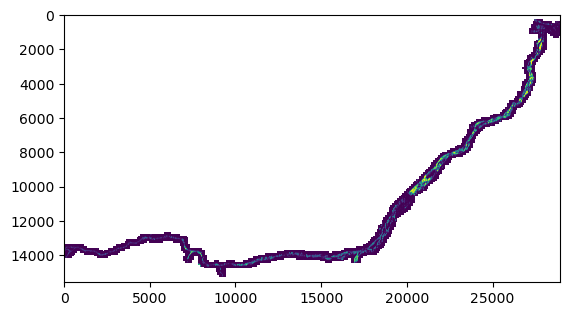

<Axes: >

In [102]:
src = "/data/sand_mining/predictions/outputs/sone/merged/scores.tif"
src = rasterio.open(src)
data = src.read(1)
show(data)

### Merge the chunk based predictions (OLD -- THIS OUTPUT IS RUBBISH)

In [64]:
prediction_base = "/data/sand_mining/predictions/outputs/sone"

In [65]:
with rasterio.Env():
    print("Reading Files", datetime.now())
    src_files_to_mosaic = [rasterio.open(f"{prediction_base}/{i}/scores.tif") for i in range(0, 10)]

    print("Making Mosaic", datetime.now())
    mosaic, out_trans = merge(src_files_to_mosaic)

    print("Writing", datetime.now())
    # Create a new raster file for the merged result
    with rasterio.open(f"/data/sand_mining/predictions/outputs/sone_merged.tif", 'w', 
                       driver='GTiff', 
                       height=mosaic.shape[1], 
                       width=mosaic.shape[2], 
                       count=1,
                       dtype=mosaic.dtype, 
                       crs=src_files_to_mosaic[0].crs, 
                       transform=out_trans) as dest:
        dest.write(mosaic)

Reading Files 2023-12-20 00:03:03.197594
Making Mosaic 2023-12-20 00:03:03.214602
Writing 2023-12-20 00:03:06.303117


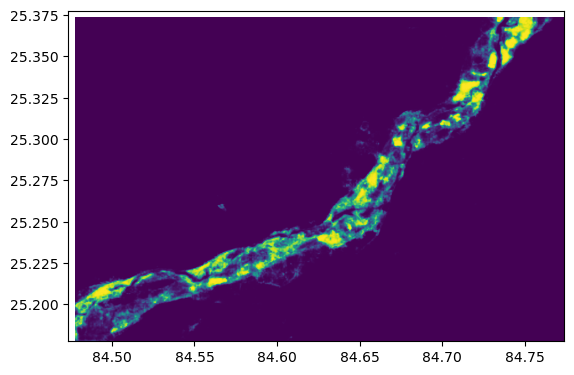

<Axes: >

In [77]:
show(src_files_to_mosaic[8])

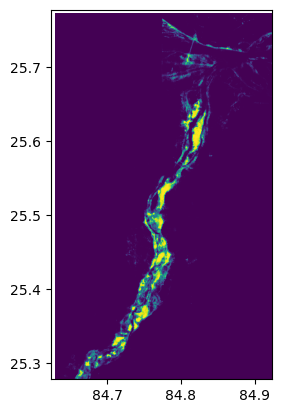

<Axes: >

In [76]:
show(src_files_to_mosaic[9])

##### OLD VIZ

  0%|          | 0/1 [00:00<?, ?it/s]

NOTE: You are averaging predictions from overlapping windows.                   
Are you sure you want to do this?


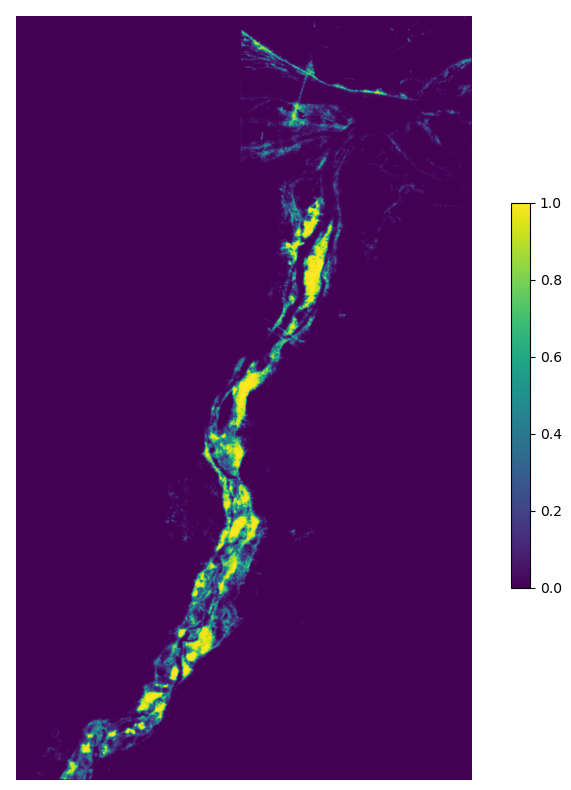

In [32]:
from tqdm.notebook import tqdm
from utils.visualizing import raster_source_to_rgb

prediction_results_list = []
crop_sz = int(config.tile_size // 5) #20% of the tiles at the edges are discarded
predictions = []


for dataset in tqdm([r_inference]):
    prediction = predictor.predict_site(dataset, crop_sz=crop_sz) 
    #store predictions for later (to save as GeoTIFFs):
    predictions.append(prediction)

    # grab the prob arrays
    prediction_score = prediction.get_score_arr(prediction.extent)[0]

#     rgb_img = raster_source_to_rgb(dataset.scene.raster_source)
#     prediction_results_list.append({
#         "predictions": prediction_score,
#         "ground_truth": dataset.scene.label_source.get_label_arr(),
#         "rgb_img": rgb_img,
#         "name": dataset.scene.id,
#         "crop_sz": crop_sz,
#     })
    
    #Now viz
    plt.figure(figsize=(10, 10))
    plt.imshow(prediction_score, vmin=0, vmax=1, cmap='viridis') 
    plt.axis('off')
#     plt.title(dataset.scene.id)
    #show colorbar at half scale
    plt.colorbar(shrink=0.5)
    plt.show()


# evaluation_results_dict = evaluate_predictions(prediction_results_list)

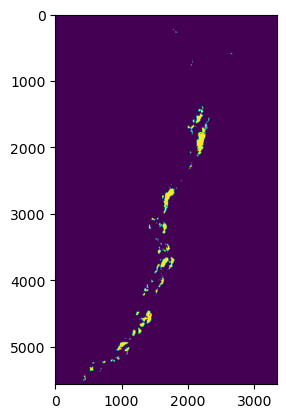

In [42]:
pred_mask = prediction_score > 0.9
plt.imshow(pred_mask)